# Coral Segmentation Model - Binary Classification

This notebook implements a binary semantic segmentation model to detect coral regions in underwater images.

**Task**: Binary segmentation (Background vs Coral)
- **Class 0**: Background (water/sand)
- **Class 1**: Coral (healthy + bleached combined)

**Model**: U-Net with pretrained ResNet50 encoder
**Framework**: PyTorch + segmentation_models_pytorch

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import GradScaler, autocast

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
from pathlib import Path
import json
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Data handling and augmentation
from sklearn.model_selection import train_test_split
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Segmentation models
import segmentation_models_pytorch as smp

# Metrics
from sklearn.metrics import confusion_matrix, classification_report

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Plotting setup
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)

print("Dependencies loaded successfully!")

Using device: cpu
Dependencies loaded successfully!


In [2]:
# Define paths
DATA_DIR = Path('../data')
IMAGES_DIR = DATA_DIR / 'images'
BLEACHED_MASKS_DIR = DATA_DIR / 'masks_bleached'
NON_BLEACHED_MASKS_DIR = DATA_DIR / 'masks_non_bleached'

# Create binary segmentation dataset
BINARY_SEG_DIR = DATA_DIR / 'binary_segmentation'
BINARY_IMAGES_DIR = BINARY_SEG_DIR / 'images'
BINARY_MASKS_DIR = BINARY_SEG_DIR / 'masks'

# Create directories
BINARY_SEG_DIR.mkdir(exist_ok=True)
BINARY_IMAGES_DIR.mkdir(exist_ok=True)
BINARY_MASKS_DIR.mkdir(exist_ok=True)

print(f"Binary segmentation dataset structure:")
print(f"  Images: {BINARY_IMAGES_DIR}")
print(f"  Binary Masks: {BINARY_MASKS_DIR}")

def create_binary_mask(bleached_mask_path, non_bleached_mask_path):
    """
    Create binary mask by combining bleached and non-bleached masks.
    
    Returns:
        binary_mask: numpy array with values:
            0 = background (black)
            255 = coral (white) - for better visualization
    """
    # Load masks
    bleached_mask = cv2.imread(str(bleached_mask_path), cv2.IMREAD_GRAYSCALE)
    non_bleached_mask = cv2.imread(str(non_bleached_mask_path), cv2.IMREAD_GRAYSCALE)
    
    if bleached_mask is None or non_bleached_mask is None:
        raise ValueError(f"Could not load masks: {bleached_mask_path}, {non_bleached_mask_path}")
    
    # Create binary mask (0 = background, 255 = coral for visibility)
    binary_mask = np.zeros_like(bleached_mask, dtype=np.uint8)
    
    # Set coral pixels to 255 (white) for better visualization
    binary_mask[non_bleached_mask > 0] = 255  # Healthy coral
    binary_mask[bleached_mask > 0] = 255      # Bleached coral
    
    return binary_mask

def get_binary_mask_statistics(mask):
    """
    Calculate statistics for binary mask.
    """
    total_pixels = mask.size
    background_pixels = np.sum(mask == 0)
    coral_pixels = np.sum(mask == 255)  # Updated to check for 255 instead of 1
    
    return {
        'total_pixels': total_pixels,
        'background_pixels': background_pixels,
        'coral_pixels': coral_pixels,
        'background_percentage': (background_pixels / total_pixels) * 100,
        'coral_percentage': (coral_pixels / total_pixels) * 100
    }

Binary segmentation dataset structure:
  Images: ../data/binary_segmentation/images
  Binary Masks: ../data/binary_segmentation/masks


Found 658 total images
  .jpg files: 512
  .JPG files: 146
\nTest binary mask creation on: C10_BC_PM_T1_29nov24_CDaza_corr.jpg
Binary mask shape: (2421, 3209)
Unique values: [  0 255]
Coral coverage: 67.36%


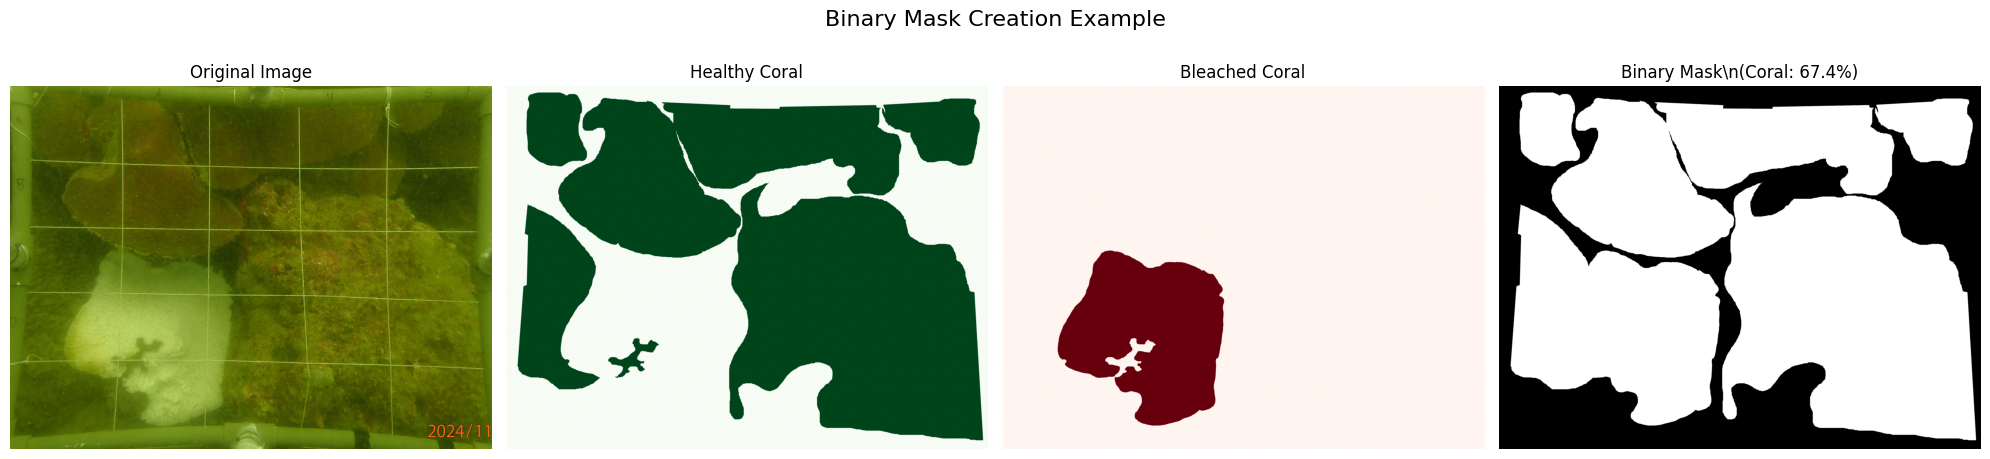

\nCreating binary segmentation dataset...


Processing images: 100%|██████████| 658/658 [01:15<00:00,  8.70it/s]

\nDataset creation complete!
Successfully processed: 658 images
Failed: 0 images
\nBinary dataset statistics:
Total images: 658
Average coral coverage: 34.4%
Coral coverage range: 0.0% - 88.4%


In [4]:
# Get all image files and create a mapping
jpg_files = sorted(list(IMAGES_DIR.glob('*.jpg')))
JPG_files = sorted(list(IMAGES_DIR.glob('*.JPG')))
all_image_files = jpg_files + JPG_files

print(f"Found {len(all_image_files)} total images")
print(f"  .jpg files: {len(jpg_files)}")
print(f"  .JPG files: {len(JPG_files)}")

# Test on first image
test_img = all_image_files[0]
base_name = test_img.stem
bleached_path = BLEACHED_MASKS_DIR / f"{base_name}_bleached.png"
non_bleached_path = NON_BLEACHED_MASKS_DIR / f"{base_name}_non_bleached.png"

if bleached_path.exists() and non_bleached_path.exists():
    binary_mask = create_binary_mask(bleached_path, non_bleached_path)
    stats = get_binary_mask_statistics(binary_mask)
    
    print(f"\\nTest binary mask creation on: {test_img.name}")
    print(f"Binary mask shape: {binary_mask.shape}")
    print(f"Unique values: {np.unique(binary_mask)}")
    print(f"Coral coverage: {stats['coral_percentage']:.2f}%")
    
    # Visualize
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    
    # Original image
    img = cv2.imread(str(test_img))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[0].imshow(img)
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    
    # Individual masks
    bleached = cv2.imread(str(bleached_path), cv2.IMREAD_GRAYSCALE)
    non_bleached = cv2.imread(str(non_bleached_path), cv2.IMREAD_GRAYSCALE)
    
    axes[1].imshow(non_bleached, cmap='Greens')
    axes[1].set_title('Healthy Coral')
    axes[1].axis('off')
    
    axes[2].imshow(bleached, cmap='Reds')
    axes[2].set_title('Bleached Coral')
    axes[2].axis('off')
    
    # Binary mask
    axes[3].imshow(binary_mask, cmap='gray')
    axes[3].set_title(f'Binary Mask\\n(Coral: {stats["coral_percentage"]:.1f}%)')
    axes[3].axis('off')
    
    plt.suptitle('Binary Mask Creation Example', fontsize=16)
    plt.tight_layout()
    plt.show()
else:
    print(f"Missing masks for {test_img.name}")

# Create binary dataset
dataset_info = []
failed_files = []

print(f"\\nCreating binary segmentation dataset...")

for img_path in tqdm(all_image_files, desc="Processing images"):
    try:
        base_name = img_path.stem
        
        # Input paths
        bleached_mask_path = BLEACHED_MASKS_DIR / f"{base_name}_bleached.png"
        non_bleached_mask_path = NON_BLEACHED_MASKS_DIR / f"{base_name}_non_bleached.png"
        
        # Check if masks exist
        if not (bleached_mask_path.exists() and non_bleached_mask_path.exists()):
            failed_files.append(img_path.name)
            continue
        
        # Output paths
        output_image_name = f"{base_name}.jpg"
        output_mask_name = f"{base_name}.png"
        
        output_image_path = BINARY_IMAGES_DIR / output_image_name
        output_mask_path = BINARY_MASKS_DIR / output_mask_name
        
        # Copy image (standardize to .jpg)
        img = cv2.imread(str(img_path))
        cv2.imwrite(str(output_image_path), img)
        
        # Create and save binary mask
        binary_mask = create_binary_mask(bleached_mask_path, non_bleached_mask_path)
        cv2.imwrite(str(output_mask_path), binary_mask)
        
        # Get statistics
        stats = get_binary_mask_statistics(binary_mask)
        
        dataset_info.append({
            'image_name': output_image_name,
            'mask_name': output_mask_name,
            'image_path': str(output_image_path),
            'mask_path': str(output_mask_path),
            'original_extension': img_path.suffix,
            **stats
        })
        
    except Exception as e:
        print(f"Failed to process {img_path.name}: {e}")
        failed_files.append(img_path.name)

print(f"\\nDataset creation complete!")
print(f"Successfully processed: {len(dataset_info)} images")
print(f"Failed: {len(failed_files)} images")

if failed_files:
    print(f"Failed files: {failed_files[:5]}{'...' if len(failed_files) > 5 else ''}")

# Create DataFrame
binary_df = pd.DataFrame(dataset_info)
print(f"\\nBinary dataset statistics:")
print(f"Total images: {len(binary_df)}")
print(f"Average coral coverage: {binary_df['coral_percentage'].mean():.1f}%")
print(f"Coral coverage range: {binary_df['coral_percentage'].min():.1f}% - {binary_df['coral_percentage'].max():.1f}%")

In [25]:
# Create stratified train/validation/test splits
print("Creating stratified dataset splits...")

# Sort by coral coverage for stratified splitting
binary_df_sorted = binary_df.sort_values('coral_percentage').reset_index(drop=True)

# Create stratified splits based on coral coverage
# First split: 80% train+val, 20% test
train_val_data, test_data = train_test_split(
    binary_df_sorted, 
    test_size=0.2, 
    stratify=pd.cut(binary_df_sorted['coral_percentage'], bins=5, labels=False),
    random_state=42
)

# Second split: 80% train, 20% val (of the remaining 80%)
train_data, val_data = train_test_split(
    train_val_data, 
    test_size=0.25,  # 0.25 * 0.8 = 0.2 of total dataset
    stratify=pd.cut(train_val_data['coral_percentage'], bins=5, labels=False),
    random_state=42
)

print(f"Dataset splits:")
print(f"Train: {len(train_data)} images ({len(train_data)/len(binary_df)*100:.1f}%)")
print(f"Validation: {len(val_data)} images ({len(val_data)/len(binary_df)*100:.1f}%)")
print(f"Test: {len(test_data)} images ({len(test_data)/len(binary_df)*100:.1f}%)")

# Check coral coverage distribution across splits
print(f"\nCoral coverage distribution:")
print(f"Train - Mean: {train_data['coral_percentage'].mean():.1f}%, Std: {train_data['coral_percentage'].std():.1f}%")
print(f"Val   - Mean: {val_data['coral_percentage'].mean():.1f}%, Std: {val_data['coral_percentage'].std():.1f}%")
print(f"Test  - Mean: {test_data['coral_percentage'].mean():.1f}%, Std: {test_data['coral_percentage'].std():.1f}%")

# Save dataset splits
splits_info = {
    'train_files': train_data['image_name'].tolist(),
    'val_files': val_data['image_name'].tolist(),
    'test_files': test_data['image_name'].tolist(),
    'split_stats': {
        'train_count': len(train_data),
        'val_count': len(val_data),
        'test_count': len(test_data),
        'train_coral_mean': train_data['coral_percentage'].mean(),
        'val_coral_mean': val_data['coral_percentage'].mean(),
        'test_coral_mean': test_data['coral_percentage'].mean()
    }
}

with open(BINARY_SEG_DIR / 'dataset_splits.json', 'w') as f:
    json.dump(splits_info, f, indent=2)

# Save complete dataset info
binary_df.to_csv(BINARY_SEG_DIR / 'binary_dataset_info.csv', index=False)

print(f"\nDataset splits saved to: {BINARY_SEG_DIR / 'dataset_splits.json'}")
print(f"Complete dataset info saved to: {BINARY_SEG_DIR / 'binary_dataset_info.csv'}")

Creating stratified dataset splits...
Dataset splits:
Train: 394 images (59.9%)
Validation: 132 images (20.1%)
Test: 132 images (20.1%)

Coral coverage distribution:
Train - Mean: 34.5%, Std: 24.8%
Val   - Mean: 34.1%, Std: 24.2%
Test  - Mean: 34.4%, Std: 23.9%

Dataset splits saved to: ../data/binary_segmentation/dataset_splits.json
Complete dataset info saved to: ../data/binary_segmentation/binary_dataset_info.csv


In [26]:
class CoralDataset(Dataset):
    """
    PyTorch Dataset for coral binary segmentation.
    """
    
    def __init__(self, dataframe, transform=None, image_size=(512, 512)):
        self.data = dataframe.reset_index(drop=True)
        self.transform = transform
        self.image_size = image_size
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        # Get file paths
        image_path = self.data.iloc[idx]['image_path']
        mask_path = self.data.iloc[idx]['mask_path']
        
        # Load image and mask
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        
        # Convert mask from 0/255 to 0/1 for training
        mask = (mask > 127).astype(np.uint8)  # Convert 255 -> 1, 0 -> 0
        
        # Resize to consistent size
        image = cv2.resize(image, self.image_size)
        mask = cv2.resize(mask, self.image_size, interpolation=cv2.INTER_NEAREST)
        
        # Apply transforms
        if self.transform:
            transformed = self.transform(image=image, mask=mask)
            image = transformed['image']
            mask = transformed['mask']
        
        # Convert to torch tensors with correct dtypes
        if not torch.is_tensor(image):
            image = torch.from_numpy(image.transpose(2, 0, 1)).float() / 255.0
        
        if not torch.is_tensor(mask):
            # Ensure mask is Long type for CrossEntropyLoss
            mask = torch.from_numpy(mask.astype(np.int64))  # Convert to int64 (Long)
        else:
            # If mask is already a tensor from transforms, ensure it's Long type
            mask = mask.long()
        
        return image, mask

# Define data augmentation transforms
def get_training_transforms(image_size=(512, 512)):
    return A.Compose([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.2),
        A.RandomRotate90(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=30, p=0.5),
        A.OneOf([
            A.ElasticTransform(p=0.3),
            A.GridDistortion(p=0.3),
            A.OpticalDistortion(p=0.3),
        ], p=0.3),
        A.OneOf([
            A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
            A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
            A.CLAHE(clip_limit=2.0, p=0.3),
        ], p=0.5),
        A.Resize(image_size[0], image_size[1]),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])

def get_validation_transforms(image_size=(512, 512)):
    return A.Compose([
        A.Resize(image_size[0], image_size[1]),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])

# Create datasets and dataloaders
IMAGE_SIZE = (512, 512)
BATCH_SIZE = 8

# Create transforms
train_transform = get_training_transforms(IMAGE_SIZE)
val_transform = get_validation_transforms(IMAGE_SIZE)

# Create datasets
train_dataset = CoralDataset(train_data, transform=train_transform, image_size=IMAGE_SIZE)
val_dataset = CoralDataset(val_data, transform=val_transform, image_size=IMAGE_SIZE)
test_dataset = CoralDataset(test_data, transform=val_transform, image_size=IMAGE_SIZE)

# Create data loaders (num_workers=0 for Jupyter notebook compatibility)
train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    num_workers=0,  # Set to 0 to avoid multiprocessing issues in Jupyter
    pin_memory=False  # Also set to False when num_workers=0
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=0,
    pin_memory=False
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=0,
    pin_memory=False
)

print(f"Dataset sizes:")
print(f"Train: {len(train_dataset)}")
print(f"Validation: {len(val_dataset)}")
print(f"Test: {len(test_dataset)}")

print(f"\\nData loaders created:")
print(f"Train batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

# Test data loading
sample_image, sample_mask = train_dataset[0]
print(f"\\nSample data shapes:")
print(f"Image: {sample_image.shape} (C, H, W)")
print(f"Mask: {sample_mask.shape} (H, W)")
print(f"Mask dtype: {sample_mask.dtype}")  # Should be torch.int64
print(f"Mask unique values: {torch.unique(sample_mask)}")
print(f"Image value range: {sample_image.min():.3f} - {sample_image.max():.3f}")

# Create U-Net model with pretrained encoder
def create_model(encoder_name='resnet50', encoder_weights='imagenet', classes=2):
    """
    Create U-Net model with pretrained encoder.
    """
    model = smp.Unet(
        encoder_name=encoder_name,
        encoder_weights=encoder_weights,
        classes=classes,
        activation=None,  # We'll apply softmax/sigmoid in loss function
        in_channels=3
    )
    return model

# Create model
model = create_model(encoder_name='resnet50', encoder_weights='imagenet', classes=2)
model = model.to(device)

print(f"\\nModel created and moved to {device}")
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

# Test model forward pass
model.eval()
with torch.no_grad():
    sample_batch = next(iter(val_loader))
    images, masks = sample_batch
    images = images.to(device)
    masks = masks.to(device)
    
    outputs = model(images)
    print(f"\\nModel output shape: {outputs.shape}")
    print(f"Input image shape: {images.shape}")
    print(f"Target mask shape: {masks.shape}")
    print(f"Target mask dtype: {masks.dtype}")  # Should be torch.int64

model.train()  # Set back to training mode

Dataset sizes:
Train: 394
Validation: 132
Test: 132
\nData loaders created:
Train batches: 50
Validation batches: 17
Test batches: 17
\nSample data shapes:
Image: torch.Size([3, 512, 512]) (C, H, W)
Mask: torch.Size([512, 512]) (H, W)
Mask dtype: torch.int64
Mask unique values: tensor([0])
Image value range: -2.118 - 2.429
\nModel created and moved to cpu
Model parameters: 32,521,250
Trainable parameters: 32,521,250
\nModel output shape: torch.Size([8, 2, 512, 512])
Input image shape: torch.Size([8, 3, 512, 512])
Target mask shape: torch.Size([8, 512, 512])
Target mask dtype: torch.int64


Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

Training dataset samples:


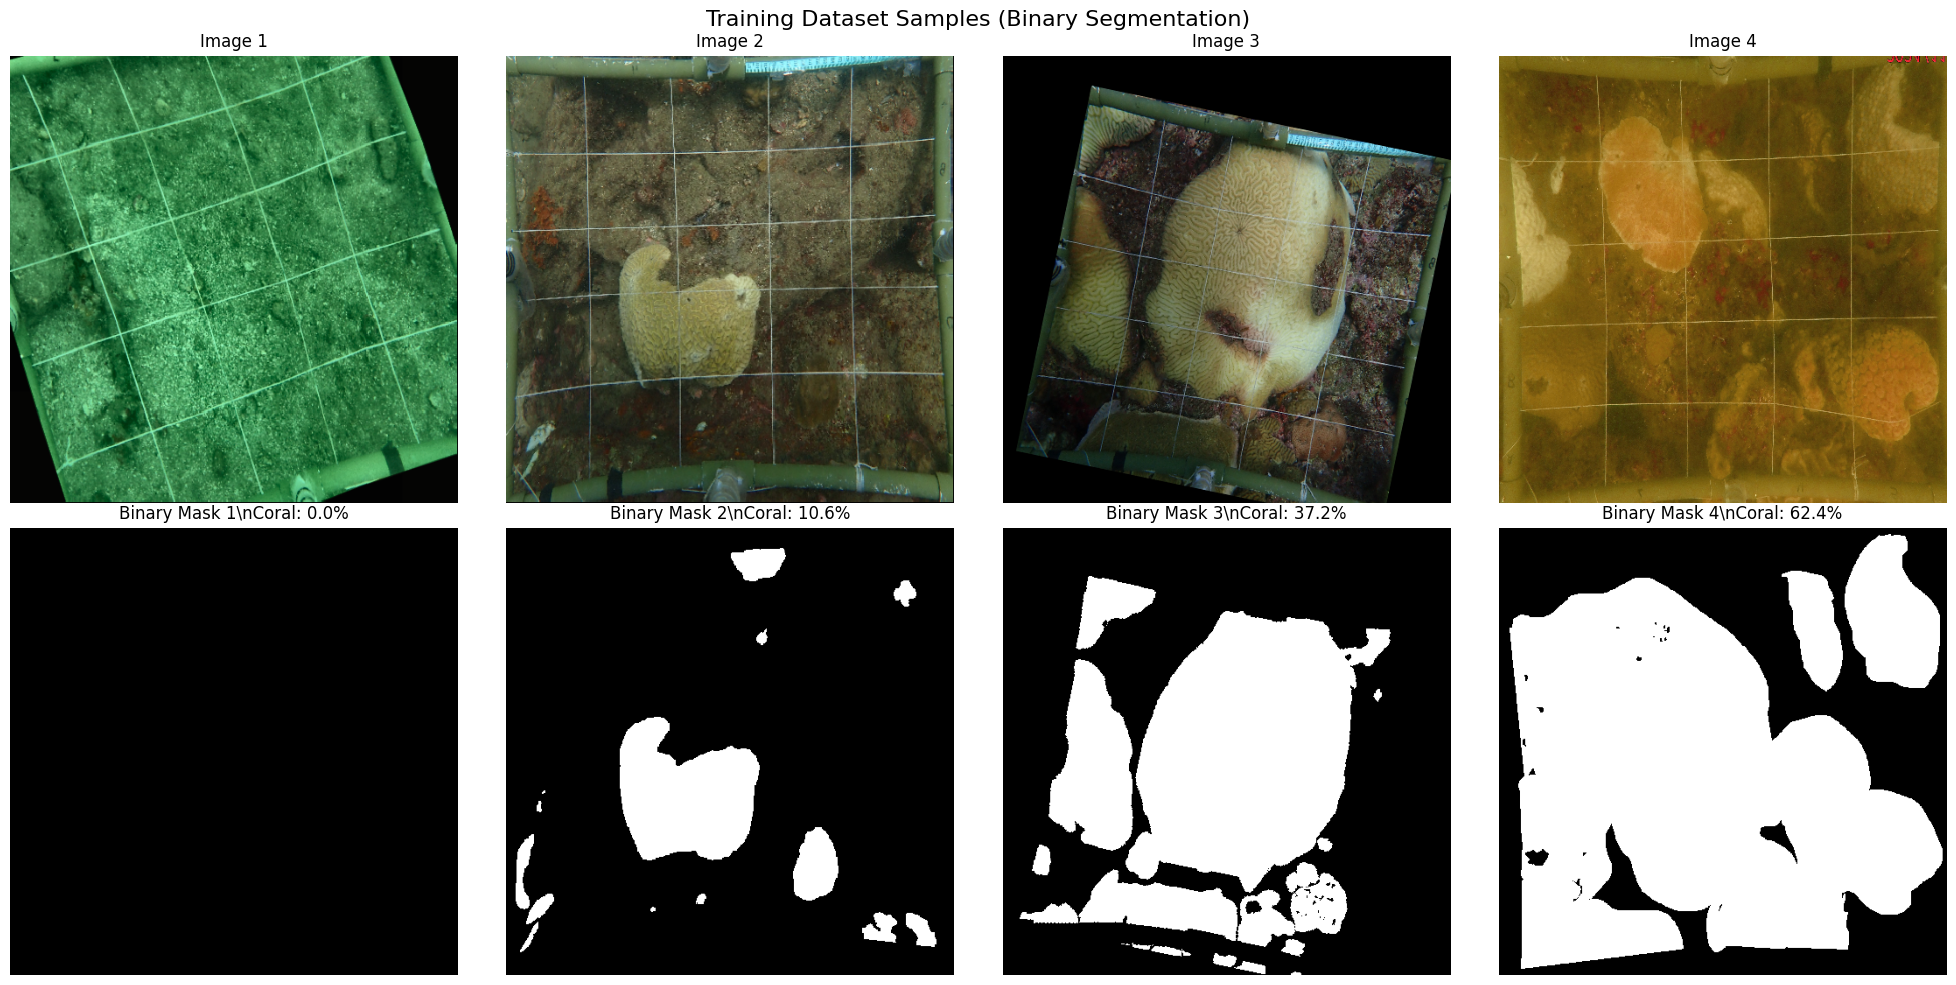

In [27]:
# Visualize some training samples
def visualize_samples(dataset, num_samples=4, figsize=(20, 10)):
    fig, axes = plt.subplots(2, num_samples, figsize=figsize)
    
    for i in range(num_samples):
        # Get sample
        image, mask = dataset[i]
        
        # Denormalize image for visualization
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        image_vis = image * std + mean
        image_vis = torch.clamp(image_vis, 0, 1)
        
        # Convert to numpy for plotting
        image_np = image_vis.permute(1, 2, 0).numpy()
        mask_np = mask.numpy()
        
        # Plot image
        axes[0, i].imshow(image_np)
        axes[0, i].set_title(f'Image {i+1}')
        axes[0, i].axis('off')
        
        # Plot mask (binary: 0=background, 1=coral)
        axes[1, i].imshow(mask_np, cmap='gray')
        coral_coverage = (mask_np == 1).sum() / mask_np.size * 100
        axes[1, i].set_title(f'Binary Mask {i+1}\\nCoral: {coral_coverage:.1f}%')
        axes[1, i].axis('off')
    
    plt.suptitle('Training Dataset Samples (Binary Segmentation)', fontsize=16)
    plt.tight_layout()
    plt.show()

# Visualize training samples
print("Training dataset samples:")
visualize_samples(train_dataset, num_samples=4)

## 5. Model Architecture - U-Net with Pretrained Encoder

In [28]:
class CombinedLoss(nn.Module):
    """
    Combined CrossEntropy + Dice Loss for better segmentation performance.
    """
    
    def __init__(self, ce_weight=0.5, dice_weight=0.5, class_weights=None):
        super().__init__()
        self.ce_weight = ce_weight
        self.dice_weight = dice_weight
        self.ce_loss = nn.CrossEntropyLoss(weight=class_weights)
    
    def dice_loss(self, pred, target, smooth=1e-6):
        # Apply softmax to predictions
        pred = F.softmax(pred, dim=1)
        
        # Convert target to one-hot
        target_one_hot = F.one_hot(target, num_classes=pred.shape[1]).permute(0, 3, 1, 2).float()
        
        # Calculate dice for each class
        dice_scores = []
        for i in range(pred.shape[1]):
            pred_i = pred[:, i]
            target_i = target_one_hot[:, i]
            
            intersection = (pred_i * target_i).sum(dim=(1, 2))
            union = pred_i.sum(dim=(1, 2)) + target_i.sum(dim=(1, 2))
            
            dice = (2.0 * intersection + smooth) / (union + smooth)
            dice_scores.append(dice)
        
        dice_scores = torch.stack(dice_scores, dim=1)
        return 1 - dice_scores.mean()
    
    def forward(self, pred, target):
        ce_loss = self.ce_loss(pred, target)
        dice_loss = self.dice_loss(pred, target)
        
        total_loss = self.ce_weight * ce_loss + self.dice_weight * dice_loss
        return total_loss, ce_loss, dice_loss

def calculate_iou(pred, target, num_classes=2):
    """
    Calculate IoU for each class.
    """
    ious = []
    
    # Convert predictions to class indices
    pred = torch.argmax(pred, dim=1)
    
    for cls in range(num_classes):
        pred_cls = (pred == cls)
        target_cls = (target == cls)
        
        intersection = (pred_cls & target_cls).sum().float()
        union = (pred_cls | target_cls).sum().float()
        
        if union == 0:
            iou = 1.0 if intersection == 0 else 0.0
        else:
            iou = intersection / union
        
        ious.append(iou)
    
    return torch.tensor(ious)

def calculate_pixel_accuracy(pred, target):
    """
    Calculate pixel accuracy.
    """
    pred = torch.argmax(pred, dim=1)
    correct = (pred == target).sum().float()
    total = target.numel()
    return correct / total

# Calculate class weights to handle class imbalance
def calculate_class_weights(dataset_df):
    """
    Calculate class weights based on pixel distribution.
    """
    total_pixels = dataset_df['total_pixels'].sum()
    background_pixels = dataset_df['background_pixels'].sum()
    coral_pixels = dataset_df['coral_pixels'].sum()
    
    # Inverse frequency weighting
    bg_weight = total_pixels / (2 * background_pixels)
    coral_weight = total_pixels / (2 * coral_pixels)
    
    weights = torch.tensor([bg_weight, coral_weight], dtype=torch.float32)
    return weights

# Calculate class weights
class_weights = calculate_class_weights(binary_df)
class_weights = class_weights.to(device)

print(f"Class weights:")
print(f"Background: {class_weights[0]:.3f}")
print(f"Coral: {class_weights[1]:.3f}")

# Create loss function
criterion = CombinedLoss(ce_weight=0.6, dice_weight=0.4, class_weights=class_weights)
print(f"\nLoss function created with CE weight: 0.6, Dice weight: 0.4")

Class weights:
Background: 0.734
Coral: 1.570

Loss function created with CE weight: 0.6, Dice weight: 0.4


## 7. Training Setup

In [ ]:
# Training hyperparameters
LEARNING_RATE = 1e-4
EPOCHS = 50
PATIENCE = 10  # Early stopping patience

# Create optimizer and scheduler
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)

scheduler = optim.lr_scheduler.CosineAnnealingLR(
    optimizer, 
    T_max=EPOCHS, 
    eta_min=1e-6
)

# Mixed precision training
scaler = GradScaler()

# Training history
history = {
    'train_loss': [],
    'train_ce_loss': [],
    'train_dice_loss': [],
    'train_iou': [],
    'train_pixel_acc': [],
    'val_loss': [],
    'val_ce_loss': [],
    'val_dice_loss': [],
    'val_iou': [],
    'val_pixel_acc': [],
    'lr': []
}

print(f"Training setup:")
print(f"Learning rate: {LEARNING_RATE}")
print(f"Epochs: {EPOCHS}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Device: {device}")
print(f"Mixed precision: Enabled")
print(f"Early stopping patience: {PATIENCE}")

Training setup:
Learning rate: 0.0001
Epochs: 50
Batch size: 8
Device: cpu
Mixed precision: Enabled
Early stopping patience: 10


## 8. Training and Validation Functions

In [30]:
def train_epoch(model, train_loader, criterion, optimizer, scaler, device):
    """
    Train for one epoch.
    """
    model.train()
    
    total_loss = 0
    total_ce_loss = 0
    total_dice_loss = 0
    total_iou = torch.zeros(2).to(device)
    total_pixel_acc = 0
    num_batches = 0
    
    pbar = tqdm(train_loader, desc='Training')
    
    for images, masks in pbar:
        images = images.to(device)
        masks = masks.to(device)
        
        optimizer.zero_grad()
        
        # Mixed precision forward pass
        with autocast():
            outputs = model(images)
            loss, ce_loss, dice_loss = criterion(outputs, masks)
        
        # Mixed precision backward pass
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        # Calculate metrics
        with torch.no_grad():
            iou = calculate_iou(outputs, masks)
            pixel_acc = calculate_pixel_accuracy(outputs, masks)
        
        # Accumulate metrics
        total_loss += loss.item()
        total_ce_loss += ce_loss.item()
        total_dice_loss += dice_loss.item()
        total_iou += iou
        total_pixel_acc += pixel_acc.item()
        num_batches += 1
        
        # Update progress bar
        pbar.set_postfix({
            'Loss': f'{loss.item():.4f}',
            'IoU': f'{iou.mean().item():.4f}',
            'PixAcc': f'{pixel_acc.item():.4f}'
        })
    
    # Average metrics
    avg_loss = total_loss / num_batches
    avg_ce_loss = total_ce_loss / num_batches
    avg_dice_loss = total_dice_loss / num_batches
    avg_iou = total_iou / num_batches
    avg_pixel_acc = total_pixel_acc / num_batches
    
    return avg_loss, avg_ce_loss, avg_dice_loss, avg_iou, avg_pixel_acc

def validate_epoch(model, val_loader, criterion, device):
    """
    Validate for one epoch.
    """
    model.eval()
    
    total_loss = 0
    total_ce_loss = 0
    total_dice_loss = 0
    total_iou = torch.zeros(2).to(device)
    total_pixel_acc = 0
    num_batches = 0
    
    pbar = tqdm(val_loader, desc='Validation')
    
    with torch.no_grad():
        for images, masks in pbar:
            images = images.to(device)
            masks = masks.to(device)
            
            # Forward pass
            outputs = model(images)
            loss, ce_loss, dice_loss = criterion(outputs, masks)
            
            # Calculate metrics
            iou = calculate_iou(outputs, masks)
            pixel_acc = calculate_pixel_accuracy(outputs, masks)
            
            # Accumulate metrics
            total_loss += loss.item()
            total_ce_loss += ce_loss.item()
            total_dice_loss += dice_loss.item()
            total_iou += iou
            total_pixel_acc += pixel_acc.item()
            num_batches += 1
            
            # Update progress bar
            pbar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'IoU': f'{iou.mean().item():.4f}',
                'PixAcc': f'{pixel_acc.item():.4f}'
            })
    
    # Average metrics
    avg_loss = total_loss / num_batches
    avg_ce_loss = total_ce_loss / num_batches
    avg_dice_loss = total_dice_loss / num_batches
    avg_iou = total_iou / num_batches
    avg_pixel_acc = total_pixel_acc / num_batches
    
    return avg_loss, avg_ce_loss, avg_dice_loss, avg_iou, avg_pixel_acc

print("Training and validation functions defined.")

Training and validation functions defined.


## 9. Model Training

In [31]:
# Training loop
best_val_iou = 0
patience_counter = 0
best_model_path = BINARY_SEG_DIR / 'best_coral_segmentation_model.pth'

print("Starting training...")
print("=" * 60)

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    print("-" * 40)
    
    # Training
    train_loss, train_ce_loss, train_dice_loss, train_iou, train_pixel_acc = train_epoch(
        model, train_loader, criterion, optimizer, scaler, device
    )
    
    # Validation
    val_loss, val_ce_loss, val_dice_loss, val_iou, val_pixel_acc = validate_epoch(
        model, val_loader, criterion, device
    )
    
    # Update learning rate
    scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']
    
    # Save metrics
    history['train_loss'].append(train_loss)
    history['train_ce_loss'].append(train_ce_loss)
    history['train_dice_loss'].append(train_dice_loss)
    history['train_iou'].append(train_iou.mean().item())
    history['train_pixel_acc'].append(train_pixel_acc)
    
    history['val_loss'].append(val_loss)
    history['val_ce_loss'].append(val_ce_loss)
    history['val_dice_loss'].append(val_dice_loss)
    history['val_iou'].append(val_iou.mean().item())
    history['val_pixel_acc'].append(val_pixel_acc)
    history['lr'].append(current_lr)
    
    # Print epoch results
    print(f"Train - Loss: {train_loss:.4f}, IoU: {train_iou.mean().item():.4f}, PixAcc: {train_pixel_acc:.4f}")
    print(f"Val   - Loss: {val_loss:.4f}, IoU: {val_iou.mean().item():.4f}, PixAcc: {val_pixel_acc:.4f}")
    print(f"Class IoU - BG: {val_iou[0].item():.4f}, Coral: {val_iou[1].item():.4f}")
    print(f"Learning Rate: {current_lr:.6f}")
    
    # Check for best model
    val_mean_iou = val_iou.mean().item()
    if val_mean_iou > best_val_iou:
        best_val_iou = val_mean_iou
        patience_counter = 0
        
        # Save best model
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'best_val_iou': best_val_iou,
            'history': history
        }, best_model_path)
        
        print(f"✓ New best model saved! IoU: {best_val_iou:.4f}")
    else:
        patience_counter += 1
        print(f"No improvement. Patience: {patience_counter}/{PATIENCE}")
    
    # Early stopping
    if patience_counter >= PATIENCE:
        print(f"\nEarly stopping triggered after {epoch+1} epochs")
        break

print("\n" + "=" * 60)
print(f"Training completed!")
print(f"Best validation IoU: {best_val_iou:.4f}")
print(f"Best model saved to: {best_model_path}")

Starting training...

Epoch 1/50
----------------------------------------


Validation: 100%|██████████| 17/17 [00:53<00:00,  3.14s/it, Loss=0.5743, IoU=0.4321, PixAcc=0.6046]


Train - Loss: 0.4853, IoU: 0.5572, PixAcc: 0.7308
Val   - Loss: 0.4746, IoU: 0.5607, PixAcc: 0.7252
Class IoU - BG: 0.6027, Coral: 0.5188
Learning Rate: 0.000100
✓ New best model saved! IoU: 0.5607

Epoch 2/50
----------------------------------------


Validation: 100%|██████████| 17/17 [00:51<00:00,  3.05s/it, Loss=0.4077, IoU=0.5505, PixAcc=0.7173]


Train - Loss: 0.4222, IoU: 0.6238, PixAcc: 0.7852
Val   - Loss: 0.3743, IoU: 0.6529, PixAcc: 0.8032
Class IoU - BG: 0.7178, Coral: 0.5881
Learning Rate: 0.000100
✓ New best model saved! IoU: 0.6529

Epoch 3/50
----------------------------------------


Validation: 100%|██████████| 17/17 [00:52<00:00,  3.07s/it, Loss=0.3739, IoU=0.5993, PixAcc=0.7609]


Train - Loss: 0.4038, IoU: 0.6384, PixAcc: 0.7969
Val   - Loss: 0.3538, IoU: 0.6623, PixAcc: 0.8110
Class IoU - BG: 0.7295, Coral: 0.5952
Learning Rate: 0.000099
✓ New best model saved! IoU: 0.6623

Epoch 4/50
----------------------------------------


Validation: 100%|██████████| 17/17 [00:52<00:00,  3.06s/it, Loss=0.3405, IoU=0.6985, PixAcc=0.8414]


Train - Loss: 0.3716, IoU: 0.6697, PixAcc: 0.8167
Val   - Loss: 0.3475, IoU: 0.6911, PixAcc: 0.8360
Class IoU - BG: 0.7733, Coral: 0.6090
Learning Rate: 0.000098
✓ New best model saved! IoU: 0.6911

Epoch 5/50
----------------------------------------


Validation: 100%|██████████| 17/17 [00:52<00:00,  3.10s/it, Loss=0.4209, IoU=0.6052, PixAcc=0.7640]


Train - Loss: 0.3653, IoU: 0.6709, PixAcc: 0.8186
Val   - Loss: 0.3675, IoU: 0.6616, PixAcc: 0.8089
Class IoU - BG: 0.7214, Coral: 0.6019
Learning Rate: 0.000098
No improvement. Patience: 1/10

Epoch 6/50
----------------------------------------


Validation: 100%|██████████| 17/17 [00:53<00:00,  3.16s/it, Loss=0.3633, IoU=0.6970, PixAcc=0.8415]


Train - Loss: 0.3590, IoU: 0.6798, PixAcc: 0.8257
Val   - Loss: 0.3227, IoU: 0.7245, PixAcc: 0.8580
Class IoU - BG: 0.8031, Coral: 0.6459
Learning Rate: 0.000097
✓ New best model saved! IoU: 0.7245

Epoch 7/50
----------------------------------------


Validation: 100%|██████████| 17/17 [00:55<00:00,  3.27s/it, Loss=0.3218, IoU=0.7025, PixAcc=0.8439]


Train - Loss: 0.3497, IoU: 0.7022, PixAcc: 0.8400
Val   - Loss: 0.3127, IoU: 0.7363, PixAcc: 0.8657
Class IoU - BG: 0.8135, Coral: 0.6592
Learning Rate: 0.000095
✓ New best model saved! IoU: 0.7363

Epoch 8/50
----------------------------------------


Validation: 100%|██████████| 17/17 [00:53<00:00,  3.12s/it, Loss=0.3146, IoU=0.7388, PixAcc=0.8665]


Train - Loss: 0.3517, IoU: 0.6889, PixAcc: 0.8275
Val   - Loss: 0.3059, IoU: 0.7415, PixAcc: 0.8679
Class IoU - BG: 0.8136, Coral: 0.6693
Learning Rate: 0.000094
✓ New best model saved! IoU: 0.7415

Epoch 9/50
----------------------------------------


Validation: 100%|██████████| 17/17 [00:53<00:00,  3.14s/it, Loss=0.2840, IoU=0.7456, PixAcc=0.8732]


Train - Loss: 0.3274, IoU: 0.7116, PixAcc: 0.8463
Val   - Loss: 0.3032, IoU: 0.7286, PixAcc: 0.8599
Class IoU - BG: 0.8041, Coral: 0.6531
Learning Rate: 0.000092
No improvement. Patience: 1/10

Epoch 10/50
----------------------------------------


Validation: 100%|██████████| 17/17 [00:53<00:00,  3.17s/it, Loss=0.3063, IoU=0.7317, PixAcc=0.8630]


Train - Loss: 0.3271, IoU: 0.7170, PixAcc: 0.8499
Val   - Loss: 0.2924, IoU: 0.7440, PixAcc: 0.8683
Class IoU - BG: 0.8128, Coral: 0.6753
Learning Rate: 0.000091
✓ New best model saved! IoU: 0.7440

Epoch 11/50
----------------------------------------


Validation: 100%|██████████| 17/17 [00:53<00:00,  3.14s/it, Loss=0.2534, IoU=0.7838, PixAcc=0.8956]


Train - Loss: 0.3212, IoU: 0.7232, PixAcc: 0.8534
Val   - Loss: 0.2882, IoU: 0.7556, PixAcc: 0.8769
Class IoU - BG: 0.8276, Coral: 0.6837
Learning Rate: 0.000089
✓ New best model saved! IoU: 0.7556

Epoch 12/50
----------------------------------------


Validation: 100%|██████████| 17/17 [00:53<00:00,  3.13s/it, Loss=0.3135, IoU=0.6881, PixAcc=0.8305]


Train - Loss: 0.2966, IoU: 0.7444, PixAcc: 0.8662
Val   - Loss: 0.2938, IoU: 0.7395, PixAcc: 0.8644
Class IoU - BG: 0.8073, Coral: 0.6718
Learning Rate: 0.000087
No improvement. Patience: 1/10

Epoch 13/50
----------------------------------------


Validation: 100%|██████████| 17/17 [00:53<00:00,  3.14s/it, Loss=0.2981, IoU=0.7265, PixAcc=0.8585]


Train - Loss: 0.3033, IoU: 0.7331, PixAcc: 0.8599
Val   - Loss: 0.2868, IoU: 0.7338, PixAcc: 0.8601
Class IoU - BG: 0.7959, Coral: 0.6717
Learning Rate: 0.000084
No improvement. Patience: 2/10

Epoch 14/50
----------------------------------------


Validation: 100%|██████████| 17/17 [00:53<00:00,  3.14s/it, Loss=0.2757, IoU=0.7612, PixAcc=0.8819]


Train - Loss: 0.2969, IoU: 0.7444, PixAcc: 0.8665
Val   - Loss: 0.2826, IoU: 0.7562, PixAcc: 0.8773
Class IoU - BG: 0.8278, Coral: 0.6846
Learning Rate: 0.000082
✓ New best model saved! IoU: 0.7562

Epoch 15/50
----------------------------------------


Validation: 100%|██████████| 17/17 [00:53<00:00,  3.13s/it, Loss=0.2635, IoU=0.8073, PixAcc=0.9114]


Train - Loss: 0.2871, IoU: 0.7577, PixAcc: 0.8760
Val   - Loss: 0.2989, IoU: 0.7498, PixAcc: 0.8748
Class IoU - BG: 0.8254, Coral: 0.6741
Learning Rate: 0.000080
No improvement. Patience: 1/10

Epoch 16/50
----------------------------------------


Validation: 100%|██████████| 17/17 [00:53<00:00,  3.13s/it, Loss=0.3134, IoU=0.6939, PixAcc=0.8332]


Train - Loss: 0.2864, IoU: 0.7523, PixAcc: 0.8720
Val   - Loss: 0.2844, IoU: 0.7374, PixAcc: 0.8623
Class IoU - BG: 0.8016, Coral: 0.6731
Learning Rate: 0.000077
No improvement. Patience: 2/10

Epoch 17/50
----------------------------------------


Validation: 100%|██████████| 17/17 [00:53<00:00,  3.12s/it, Loss=0.2434, IoU=0.7791, PixAcc=0.8917]


Train - Loss: 0.2962, IoU: 0.7419, PixAcc: 0.8666
Val   - Loss: 0.2704, IoU: 0.7645, PixAcc: 0.8811
Class IoU - BG: 0.8296, Coral: 0.6995
Learning Rate: 0.000074
✓ New best model saved! IoU: 0.7645

Epoch 18/50
----------------------------------------


Validation: 100%|██████████| 17/17 [00:53<00:00,  3.14s/it, Loss=0.2334, IoU=0.8004, PixAcc=0.9055]


Train - Loss: 0.2717, IoU: 0.7622, PixAcc: 0.8783
Val   - Loss: 0.2845, IoU: 0.7581, PixAcc: 0.8782
Class IoU - BG: 0.8305, Coral: 0.6856
Learning Rate: 0.000072
No improvement. Patience: 1/10

Epoch 19/50
----------------------------------------


Validation: 100%|██████████| 17/17 [00:53<00:00,  3.13s/it, Loss=0.2247, IoU=0.8097, PixAcc=0.9108]


Train - Loss: 0.2745, IoU: 0.7632, PixAcc: 0.8796
Val   - Loss: 0.2931, IoU: 0.7507, PixAcc: 0.8724
Class IoU - BG: 0.8200, Coral: 0.6815
Learning Rate: 0.000069
No improvement. Patience: 2/10

Epoch 20/50
----------------------------------------


Validation: 100%|██████████| 17/17 [00:51<00:00,  3.03s/it, Loss=0.2356, IoU=0.7864, PixAcc=0.8968]


Train - Loss: 0.2687, IoU: 0.7678, PixAcc: 0.8822
Val   - Loss: 0.2963, IoU: 0.7460, PixAcc: 0.8703
Class IoU - BG: 0.8194, Coral: 0.6726
Learning Rate: 0.000066
No improvement. Patience: 3/10

Epoch 21/50
----------------------------------------


Validation: 100%|██████████| 17/17 [00:51<00:00,  3.02s/it, Loss=0.2561, IoU=0.7606, PixAcc=0.8802]


Train - Loss: 0.2576, IoU: 0.7742, PixAcc: 0.8837
Val   - Loss: 0.2716, IoU: 0.7599, PixAcc: 0.8769
Class IoU - BG: 0.8220, Coral: 0.6978
Learning Rate: 0.000063
No improvement. Patience: 4/10

Epoch 22/50
----------------------------------------


Validation: 100%|██████████| 17/17 [00:52<00:00,  3.09s/it, Loss=0.2594, IoU=0.7745, PixAcc=0.8898]


Train - Loss: 0.2520, IoU: 0.7815, PixAcc: 0.8899
Val   - Loss: 0.2836, IoU: 0.7525, PixAcc: 0.8737
Class IoU - BG: 0.8225, Coral: 0.6826
Learning Rate: 0.000060
No improvement. Patience: 5/10

Epoch 23/50
----------------------------------------


Validation: 100%|██████████| 17/17 [00:52<00:00,  3.08s/it, Loss=0.2161, IoU=0.8124, PixAcc=0.9119]


Train - Loss: 0.2474, IoU: 0.7892, PixAcc: 0.8935
Val   - Loss: 0.2935, IoU: 0.7569, PixAcc: 0.8767
Class IoU - BG: 0.8273, Coral: 0.6865
Learning Rate: 0.000057
No improvement. Patience: 6/10

Epoch 24/50
----------------------------------------


Validation: 100%|██████████| 17/17 [00:52<00:00,  3.07s/it, Loss=0.2843, IoU=0.7451, PixAcc=0.8688]


Train - Loss: 0.2498, IoU: 0.7779, PixAcc: 0.8869
Val   - Loss: 0.2813, IoU: 0.7435, PixAcc: 0.8665
Class IoU - BG: 0.8094, Coral: 0.6776
Learning Rate: 0.000054
No improvement. Patience: 7/10

Epoch 25/50
----------------------------------------


Validation: 100%|██████████| 17/17 [00:53<00:00,  3.13s/it, Loss=0.2188, IoU=0.8088, PixAcc=0.9087]


Train - Loss: 0.2488, IoU: 0.7796, PixAcc: 0.8894
Val   - Loss: 0.2803, IoU: 0.7579, PixAcc: 0.8768
Class IoU - BG: 0.8258, Coral: 0.6900
Learning Rate: 0.000050
No improvement. Patience: 8/10

Epoch 26/50
----------------------------------------


Validation: 100%|██████████| 17/17 [00:53<00:00,  3.16s/it, Loss=0.2052, IoU=0.8248, PixAcc=0.9189]


Train - Loss: 0.2468, IoU: 0.7870, PixAcc: 0.8935
Val   - Loss: 0.3038, IoU: 0.7735, PixAcc: 0.8882
Class IoU - BG: 0.8450, Coral: 0.7020
Learning Rate: 0.000047
✓ New best model saved! IoU: 0.7735

Epoch 27/50
----------------------------------------


Validation: 100%|██████████| 17/17 [00:52<00:00,  3.07s/it, Loss=0.2055, IoU=0.8143, PixAcc=0.9125]


Train - Loss: 0.2332, IoU: 0.8005, PixAcc: 0.9020
Val   - Loss: 0.2854, IoU: 0.7653, PixAcc: 0.8827
Class IoU - BG: 0.8351, Coral: 0.6955
Learning Rate: 0.000044
No improvement. Patience: 1/10

Epoch 28/50
----------------------------------------


Validation: 100%|██████████| 17/17 [00:52<00:00,  3.07s/it, Loss=0.2275, IoU=0.7965, PixAcc=0.9028]


Train - Loss: 0.2238, IoU: 0.8095, PixAcc: 0.9071
Val   - Loss: 0.2778, IoU: 0.7647, PixAcc: 0.8817
Class IoU - BG: 0.8332, Coral: 0.6963
Learning Rate: 0.000041
No improvement. Patience: 2/10

Epoch 29/50
----------------------------------------


Validation: 100%|██████████| 17/17 [00:52<00:00,  3.07s/it, Loss=0.2381, IoU=0.7880, PixAcc=0.8989]


Train - Loss: 0.2325, IoU: 0.7914, PixAcc: 0.8993
Val   - Loss: 0.2878, IoU: 0.7580, PixAcc: 0.8780
Class IoU - BG: 0.8293, Coral: 0.6866
Learning Rate: 0.000038
No improvement. Patience: 3/10

Epoch 30/50
----------------------------------------


Validation: 100%|██████████| 17/17 [00:52<00:00,  3.08s/it, Loss=0.2146, IoU=0.8053, PixAcc=0.9087]


Train - Loss: 0.2214, IoU: 0.8131, PixAcc: 0.9086
Val   - Loss: 0.2948, IoU: 0.7677, PixAcc: 0.8840
Class IoU - BG: 0.8377, Coral: 0.6977
Learning Rate: 0.000035
No improvement. Patience: 4/10

Epoch 31/50
----------------------------------------


Validation: 100%|██████████| 17/17 [00:52<00:00,  3.08s/it, Loss=0.2250, IoU=0.8018, PixAcc=0.9065]


Train - Loss: 0.2141, IoU: 0.8193, PixAcc: 0.9112
Val   - Loss: 0.2902, IoU: 0.7651, PixAcc: 0.8821
Class IoU - BG: 0.8346, Coral: 0.6956
Learning Rate: 0.000032
No improvement. Patience: 5/10

Epoch 32/50
----------------------------------------


Validation: 100%|██████████| 17/17 [00:52<00:00,  3.06s/it, Loss=0.2259, IoU=0.7890, PixAcc=0.8974]


Train - Loss: 0.2083, IoU: 0.8201, PixAcc: 0.9122
Val   - Loss: 0.2803, IoU: 0.7597, PixAcc: 0.8773
Class IoU - BG: 0.8262, Coral: 0.6931
Learning Rate: 0.000029
No improvement. Patience: 6/10

Epoch 33/50
----------------------------------------


Validation: 100%|██████████| 17/17 [00:52<00:00,  3.07s/it, Loss=0.2245, IoU=0.7964, PixAcc=0.9043]


Train - Loss: 0.2162, IoU: 0.8129, PixAcc: 0.9085
Val   - Loss: 0.2980, IoU: 0.7648, PixAcc: 0.8825
Class IoU - BG: 0.8360, Coral: 0.6935
Learning Rate: 0.000027
No improvement. Patience: 7/10

Epoch 34/50
----------------------------------------


Validation: 100%|██████████| 17/17 [00:51<00:00,  3.04s/it, Loss=0.2225, IoU=0.7911, PixAcc=0.8999]


Train - Loss: 0.2143, IoU: 0.8183, PixAcc: 0.9119
Val   - Loss: 0.2746, IoU: 0.7747, PixAcc: 0.8872
Class IoU - BG: 0.8402, Coral: 0.7092
Learning Rate: 0.000024
✓ New best model saved! IoU: 0.7747

Epoch 35/50
----------------------------------------


Validation: 100%|██████████| 17/17 [00:51<00:00,  3.04s/it, Loss=0.2169, IoU=0.8021, PixAcc=0.9060]


Train - Loss: 0.2159, IoU: 0.8104, PixAcc: 0.9100
Val   - Loss: 0.2798, IoU: 0.7670, PixAcc: 0.8832
Class IoU - BG: 0.8354, Coral: 0.6986
Learning Rate: 0.000021
No improvement. Patience: 1/10

Epoch 36/50
----------------------------------------


Validation: 100%|██████████| 17/17 [00:52<00:00,  3.07s/it, Loss=0.2074, IoU=0.8119, PixAcc=0.9118]


Train - Loss: 0.2002, IoU: 0.8266, PixAcc: 0.9161
Val   - Loss: 0.2952, IoU: 0.7670, PixAcc: 0.8833
Class IoU - BG: 0.8361, Coral: 0.6979
Learning Rate: 0.000019
No improvement. Patience: 2/10

Epoch 37/50
----------------------------------------


Validation: 100%|██████████| 17/17 [00:52<00:00,  3.08s/it, Loss=0.2184, IoU=0.7938, PixAcc=0.9015]


Train - Loss: 0.1989, IoU: 0.8348, PixAcc: 0.9199
Val   - Loss: 0.2852, IoU: 0.7749, PixAcc: 0.8880
Class IoU - BG: 0.8419, Coral: 0.7078
Learning Rate: 0.000017
✓ New best model saved! IoU: 0.7749

Epoch 38/50
----------------------------------------


Validation: 100%|██████████| 17/17 [00:51<00:00,  3.06s/it, Loss=0.2170, IoU=0.7977, PixAcc=0.9036]


Train - Loss: 0.1920, IoU: 0.8373, PixAcc: 0.9224
Val   - Loss: 0.2926, IoU: 0.7607, PixAcc: 0.8790
Class IoU - BG: 0.8290, Coral: 0.6925
Learning Rate: 0.000014
No improvement. Patience: 1/10

Epoch 39/50
----------------------------------------


Validation: 100%|██████████| 17/17 [00:52<00:00,  3.06s/it, Loss=0.2154, IoU=0.8065, PixAcc=0.9095]


Train - Loss: 0.1968, IoU: 0.8335, PixAcc: 0.9192
Val   - Loss: 0.2915, IoU: 0.7724, PixAcc: 0.8873
Class IoU - BG: 0.8425, Coral: 0.7024
Learning Rate: 0.000012
No improvement. Patience: 2/10

Epoch 40/50
----------------------------------------


Validation: 100%|██████████| 17/17 [00:52<00:00,  3.06s/it, Loss=0.2199, IoU=0.8055, PixAcc=0.9096]


Train - Loss: 0.1880, IoU: 0.8372, PixAcc: 0.9231
Val   - Loss: 0.3002, IoU: 0.7699, PixAcc: 0.8854
Class IoU - BG: 0.8395, Coral: 0.7002
Learning Rate: 0.000010
No improvement. Patience: 3/10

Epoch 41/50
----------------------------------------


Validation: 100%|██████████| 17/17 [00:52<00:00,  3.06s/it, Loss=0.2084, IoU=0.8083, PixAcc=0.9102]


Train - Loss: 0.1844, IoU: 0.8408, PixAcc: 0.9249
Val   - Loss: 0.2901, IoU: 0.7695, PixAcc: 0.8846
Class IoU - BG: 0.8378, Coral: 0.7013
Learning Rate: 0.000009
No improvement. Patience: 4/10

Epoch 42/50
----------------------------------------


Validation: 100%|██████████| 17/17 [00:52<00:00,  3.07s/it, Loss=0.2254, IoU=0.7922, PixAcc=0.9010]


Train - Loss: 0.1868, IoU: 0.8406, PixAcc: 0.9230
Val   - Loss: 0.2876, IoU: 0.7661, PixAcc: 0.8828
Class IoU - BG: 0.8349, Coral: 0.6973
Learning Rate: 0.000007
No improvement. Patience: 5/10

Epoch 43/50
----------------------------------------


Validation: 100%|██████████| 17/17 [00:52<00:00,  3.08s/it, Loss=0.2218, IoU=0.7950, PixAcc=0.9023]


Train - Loss: 0.1847, IoU: 0.8436, PixAcc: 0.9260
Val   - Loss: 0.2974, IoU: 0.7660, PixAcc: 0.8829
Class IoU - BG: 0.8359, Coral: 0.6962
Learning Rate: 0.000006
No improvement. Patience: 6/10

Epoch 44/50
----------------------------------------


Validation: 100%|██████████| 17/17 [00:52<00:00,  3.08s/it, Loss=0.2097, IoU=0.8067, PixAcc=0.9093]


Train - Loss: 0.1839, IoU: 0.8413, PixAcc: 0.9240
Val   - Loss: 0.2979, IoU: 0.7683, PixAcc: 0.8846
Class IoU - BG: 0.8391, Coral: 0.6975
Learning Rate: 0.000004
No improvement. Patience: 7/10

Epoch 45/50
----------------------------------------


Validation: 100%|██████████| 17/17 [00:51<00:00,  3.05s/it, Loss=0.2125, IoU=0.8030, PixAcc=0.9071]


Train - Loss: 0.1844, IoU: 0.8440, PixAcc: 0.9256
Val   - Loss: 0.2968, IoU: 0.7688, PixAcc: 0.8844
Class IoU - BG: 0.8379, Coral: 0.6996
Learning Rate: 0.000003
No improvement. Patience: 8/10

Epoch 46/50
----------------------------------------


Validation: 100%|██████████| 17/17 [00:52<00:00,  3.07s/it, Loss=0.2179, IoU=0.8002, PixAcc=0.9058]


Train - Loss: 0.1776, IoU: 0.8495, PixAcc: 0.9281
Val   - Loss: 0.2963, IoU: 0.7679, PixAcc: 0.8839
Class IoU - BG: 0.8369, Coral: 0.6988
Learning Rate: 0.000003
No improvement. Patience: 9/10

Epoch 47/50
----------------------------------------


Validation: 100%|██████████| 17/17 [00:52<00:00,  3.06s/it, Loss=0.2163, IoU=0.8006, PixAcc=0.9058]

Train - Loss: 0.1804, IoU: 0.8459, PixAcc: 0.9253
Val   - Loss: 0.3046, IoU: 0.7697, PixAcc: 0.8850
Class IoU - BG: 0.8387, Coral: 0.7006
Learning Rate: 0.000002
No improvement. Patience: 10/10

Early stopping triggered after 47 epochs

Training completed!
Best validation IoU: 0.7749
Best model saved to: ../data/binary_segmentation/best_coral_segmentation_model.pth


## 10. Training Results Visualization

Training History:


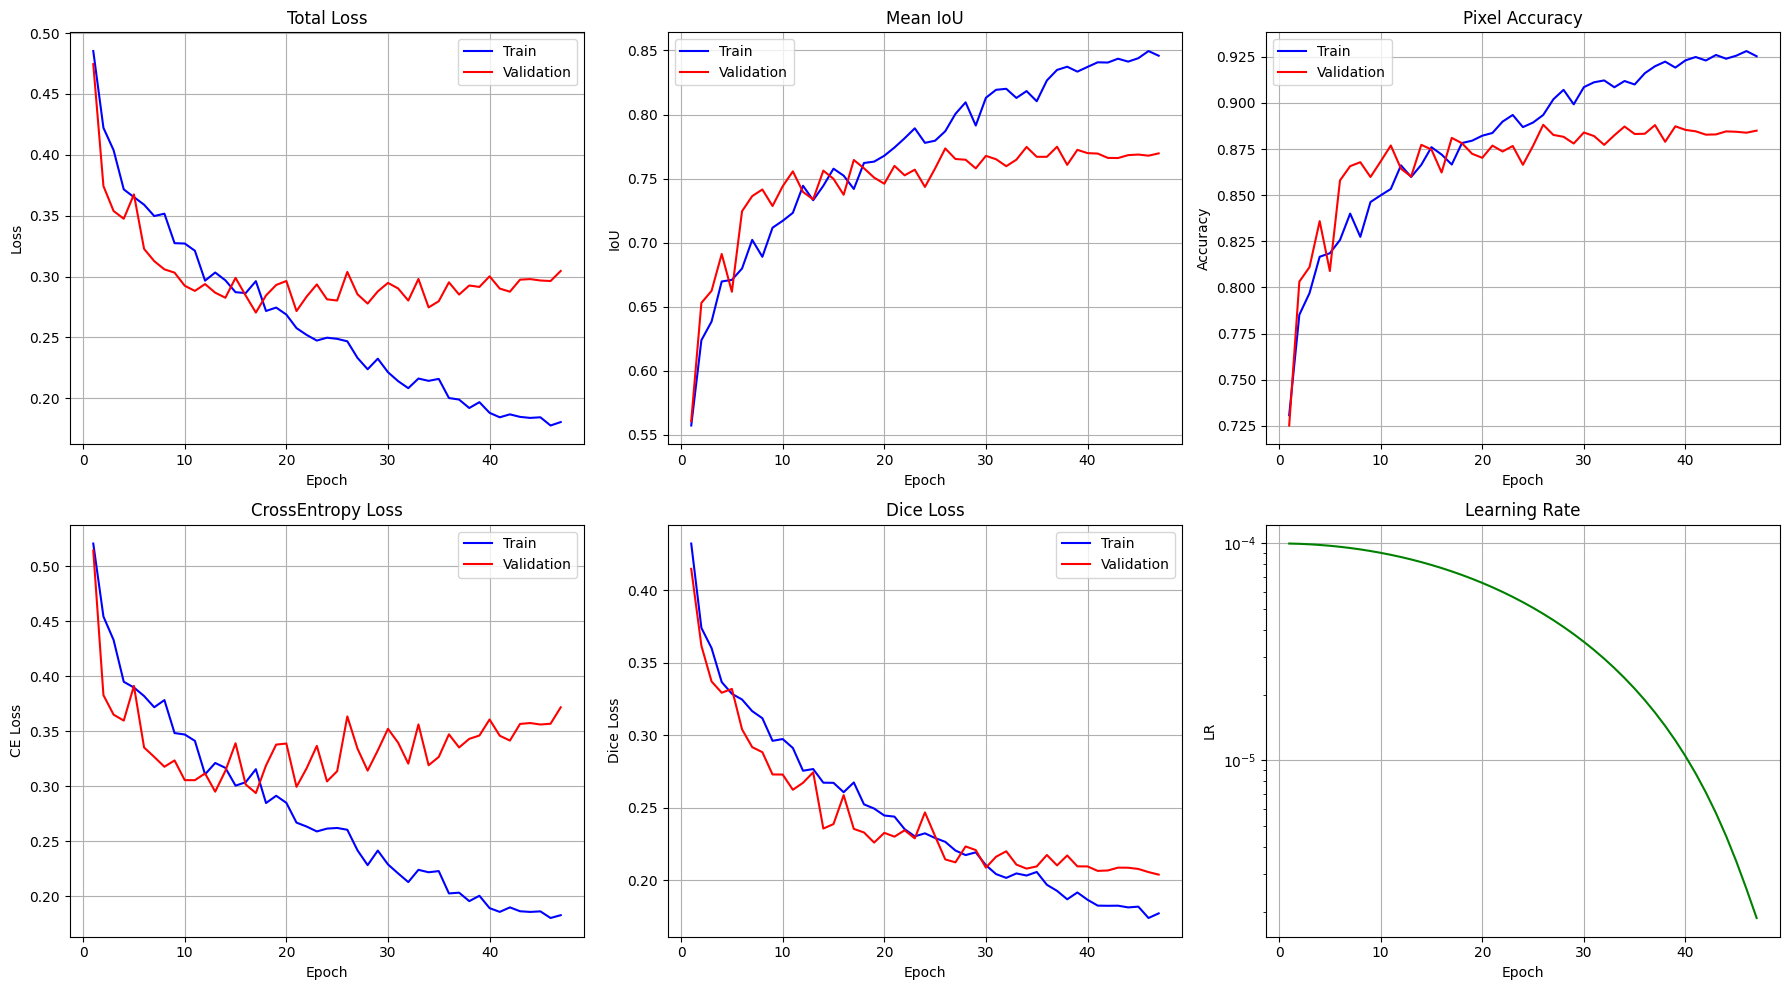


Final Training Metrics:
Train IoU: 0.8459
Val IoU: 0.7697
Train Pixel Acc: 0.9253
Val Pixel Acc: 0.8850
Best Val IoU: 0.7749

Training history saved to: ../data/binary_segmentation/training_history.csv


In [32]:
# Plot training history
def plot_training_history(history):
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    
    epochs = range(1, len(history['train_loss']) + 1)
    
    # Loss
    axes[0, 0].plot(epochs, history['train_loss'], 'b-', label='Train')
    axes[0, 0].plot(epochs, history['val_loss'], 'r-', label='Validation')
    axes[0, 0].set_title('Total Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True)
    
    # IoU
    axes[0, 1].plot(epochs, history['train_iou'], 'b-', label='Train')
    axes[0, 1].plot(epochs, history['val_iou'], 'r-', label='Validation')
    axes[0, 1].set_title('Mean IoU')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('IoU')
    axes[0, 1].legend()
    axes[0, 1].grid(True)
    
    # Pixel Accuracy
    axes[0, 2].plot(epochs, history['train_pixel_acc'], 'b-', label='Train')
    axes[0, 2].plot(epochs, history['val_pixel_acc'], 'r-', label='Validation')
    axes[0, 2].set_title('Pixel Accuracy')
    axes[0, 2].set_xlabel('Epoch')
    axes[0, 2].set_ylabel('Accuracy')
    axes[0, 2].legend()
    axes[0, 2].grid(True)
    
    # CrossEntropy Loss
    axes[1, 0].plot(epochs, history['train_ce_loss'], 'b-', label='Train')
    axes[1, 0].plot(epochs, history['val_ce_loss'], 'r-', label='Validation')
    axes[1, 0].set_title('CrossEntropy Loss')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('CE Loss')
    axes[1, 0].legend()
    axes[1, 0].grid(True)
    
    # Dice Loss
    axes[1, 1].plot(epochs, history['train_dice_loss'], 'b-', label='Train')
    axes[1, 1].plot(epochs, history['val_dice_loss'], 'r-', label='Validation')
    axes[1, 1].set_title('Dice Loss')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Dice Loss')
    axes[1, 1].legend()
    axes[1, 1].grid(True)
    
    # Learning Rate
    axes[1, 2].plot(epochs, history['lr'], 'g-')
    axes[1, 2].set_title('Learning Rate')
    axes[1, 2].set_xlabel('Epoch')
    axes[1, 2].set_ylabel('LR')
    axes[1, 2].set_yscale('log')
    axes[1, 2].grid(True)
    
    plt.tight_layout()
    plt.show()

# Plot training history
print("Training History:")
plot_training_history(history)

# Print final metrics
print(f"\nFinal Training Metrics:")
print(f"Train IoU: {history['train_iou'][-1]:.4f}")
print(f"Val IoU: {history['val_iou'][-1]:.4f}")
print(f"Train Pixel Acc: {history['train_pixel_acc'][-1]:.4f}")
print(f"Val Pixel Acc: {history['val_pixel_acc'][-1]:.4f}")
print(f"Best Val IoU: {best_val_iou:.4f}")

# Save training history
history_df = pd.DataFrame(history)
history_df.to_csv(BINARY_SEG_DIR / 'training_history.csv', index=False)
print(f"\nTraining history saved to: {BINARY_SEG_DIR / 'training_history.csv'}")

## 11. Model Evaluation on Test Set

Loaded best model from epoch 36


Validation: 100%|██████████| 17/17 [00:52<00:00,  3.10s/it, Loss=0.9662, IoU=0.5726, PixAcc=0.7755]



FINAL TEST SET EVALUATION
Test Loss: 0.4293
Test Mean IoU: 0.7021
Test Background IoU: 0.7978
Test Coral IoU: 0.6065
Test Pixel Accuracy: 0.8475
Test CE Loss: 0.5504
Test Dice Loss: 0.2477


Detailed evaluation: 100%|██████████| 17/17 [00:50<00:00,  2.96s/it]



Confusion Matrix:
                 Predicted
Actual    BG     Coral
BG     20918304   1793687
Coral   3409221   8481796

Classification Report:
              precision    recall  f1-score   support

  Background       0.86      0.92      0.89  22711991
       Coral       0.83      0.71      0.77  11891017

    accuracy                           0.85  34603008
   macro avg       0.84      0.82      0.83  34603008
weighted avg       0.85      0.85      0.85  34603008


Coral Coverage Estimation:
Mean Absolute Error: 9.58%
Root Mean Square Error: 15.40%


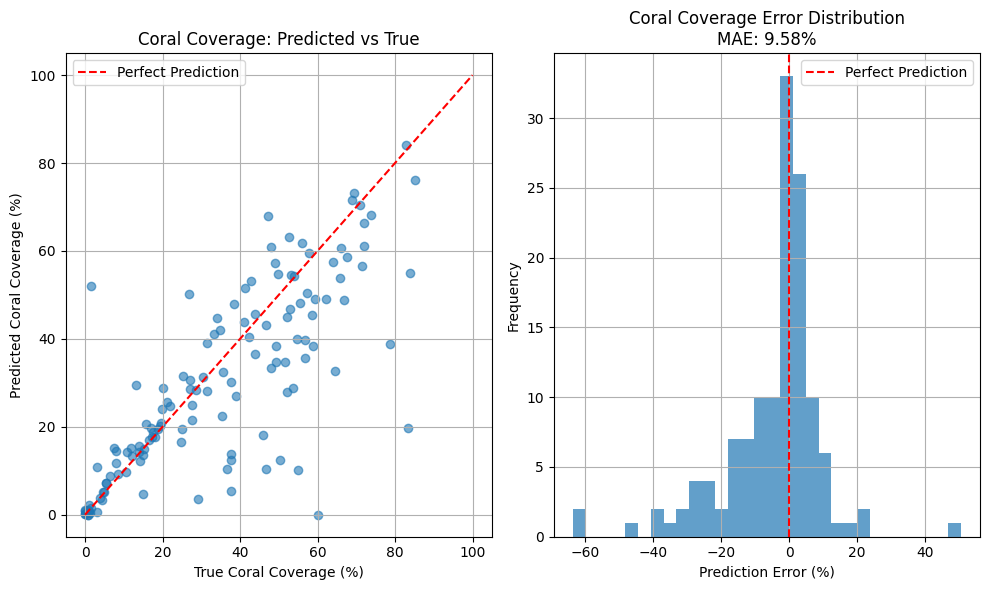

In [33]:
# Load best model for evaluation
checkpoint = torch.load(best_model_path)
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded best model from epoch {checkpoint['epoch']}")

# Evaluate on test set
test_loss, test_ce_loss, test_dice_loss, test_iou, test_pixel_acc = validate_epoch(
    model, test_loader, criterion, device
)

print(f"\n" + "="*50)
print(f"FINAL TEST SET EVALUATION")
print(f"="*50)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Mean IoU: {test_iou.mean().item():.4f}")
print(f"Test Background IoU: {test_iou[0].item():.4f}")
print(f"Test Coral IoU: {test_iou[1].item():.4f}")
print(f"Test Pixel Accuracy: {test_pixel_acc:.4f}")
print(f"Test CE Loss: {test_ce_loss:.4f}")
print(f"Test Dice Loss: {test_dice_loss:.4f}")

# Calculate additional metrics on test set
def evaluate_detailed_metrics(model, test_loader, device):
    model.eval()
    
    all_predictions = []
    all_targets = []
    coral_coverage_predictions = []
    coral_coverage_targets = []
    
    with torch.no_grad():
        for images, masks in tqdm(test_loader, desc="Detailed evaluation"):
            images = images.to(device)
            masks = masks.to(device)
            
            outputs = model(images)
            predictions = torch.argmax(outputs, dim=1)
            
            # Flatten for confusion matrix
            all_predictions.append(predictions.cpu().numpy().flatten())
            all_targets.append(masks.cpu().numpy().flatten())
            
            # Calculate coral coverage for each image in batch
            for i in range(masks.shape[0]):
                pred_coverage = (predictions[i] == 1).sum().item() / predictions[i].numel() * 100
                true_coverage = (masks[i] == 1).sum().item() / masks[i].numel() * 100
                
                coral_coverage_predictions.append(pred_coverage)
                coral_coverage_targets.append(true_coverage)
    
    # Combine all predictions and targets
    all_predictions = np.concatenate(all_predictions)
    all_targets = np.concatenate(all_targets)
    
    return all_predictions, all_targets, coral_coverage_predictions, coral_coverage_targets

# Get detailed metrics
all_preds, all_targets, coverage_preds, coverage_targets = evaluate_detailed_metrics(model, test_loader, device)

# Confusion matrix
cm = confusion_matrix(all_targets, all_preds)
print(f"\nConfusion Matrix:")
print(f"                 Predicted")
print(f"Actual    BG     Coral")
print(f"BG     {cm[0,0]:8d}  {cm[0,1]:8d}")
print(f"Coral  {cm[1,0]:8d}  {cm[1,1]:8d}")

# Classification report
print(f"\nClassification Report:")
print(classification_report(all_targets, all_preds, target_names=['Background', 'Coral']))

# Coral coverage accuracy
coverage_mae = np.mean(np.abs(np.array(coverage_preds) - np.array(coverage_targets)))
coverage_rmse = np.sqrt(np.mean((np.array(coverage_preds) - np.array(coverage_targets))**2))

print(f"\nCoral Coverage Estimation:")
print(f"Mean Absolute Error: {coverage_mae:.2f}%")
print(f"Root Mean Square Error: {coverage_rmse:.2f}%")

# Visualize coral coverage predictions vs targets
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.scatter(coverage_targets, coverage_preds, alpha=0.6)
plt.plot([0, 100], [0, 100], 'r--', label='Perfect Prediction')
plt.xlabel('True Coral Coverage (%)')
plt.ylabel('Predicted Coral Coverage (%)')
plt.title('Coral Coverage: Predicted vs True')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
errors = np.array(coverage_preds) - np.array(coverage_targets)
plt.hist(errors, bins=30, alpha=0.7)
plt.xlabel('Prediction Error (%)')
plt.ylabel('Frequency')
plt.title(f'Coral Coverage Error Distribution\nMAE: {coverage_mae:.2f}%')
plt.axvline(0, color='red', linestyle='--', label='Perfect Prediction')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

print(f"\n" + "="*50)

## 12. Model Predictions Visualization

Sample predictions on test set:


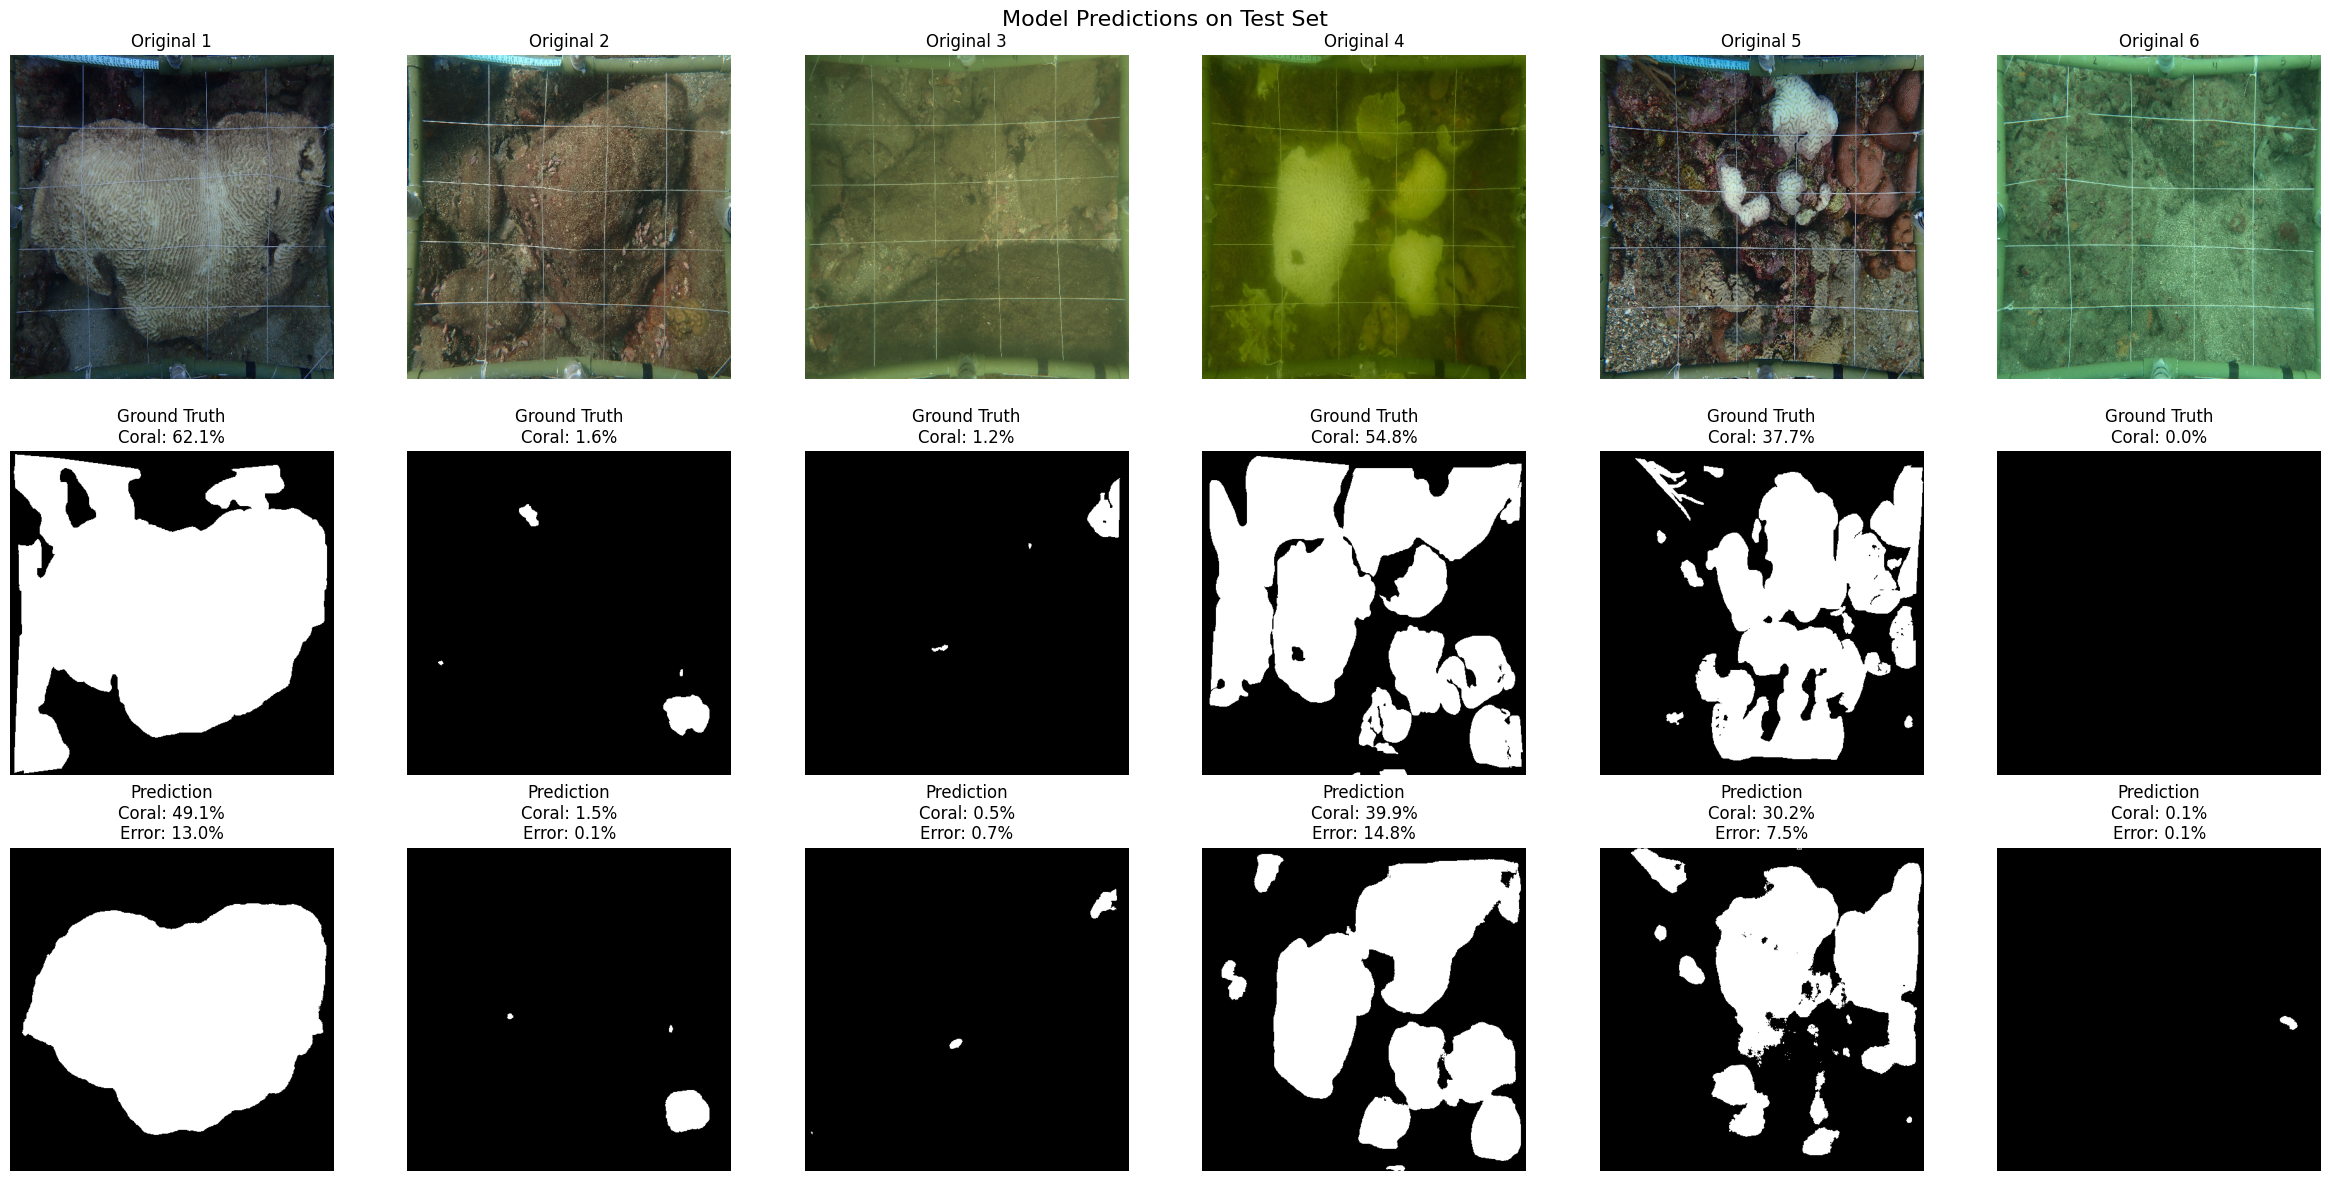


Best predictions (lowest coverage error):


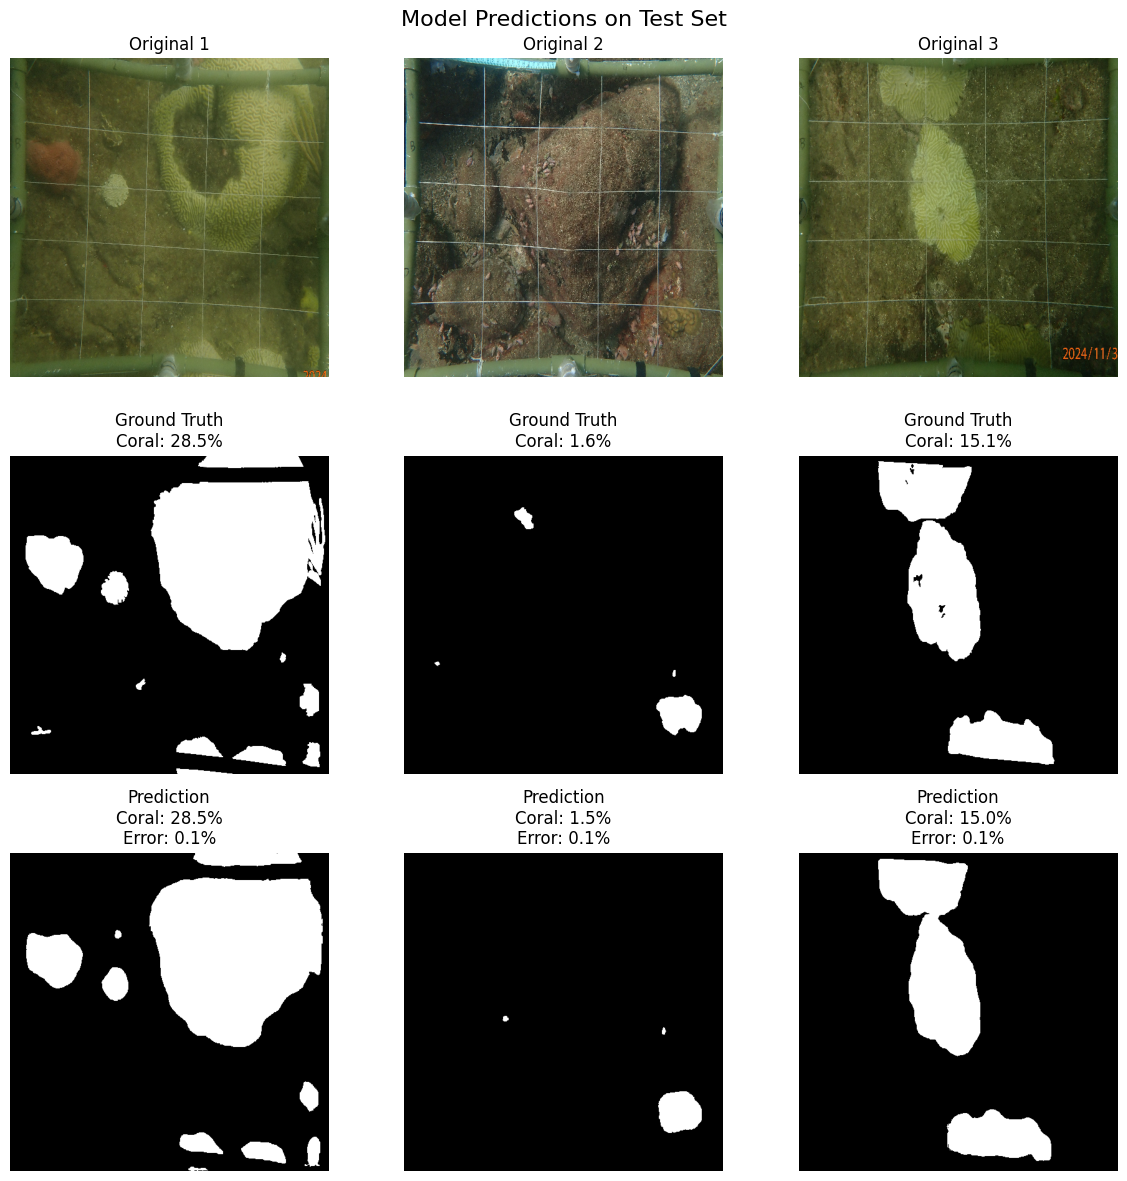


Worst predictions (highest coverage error):


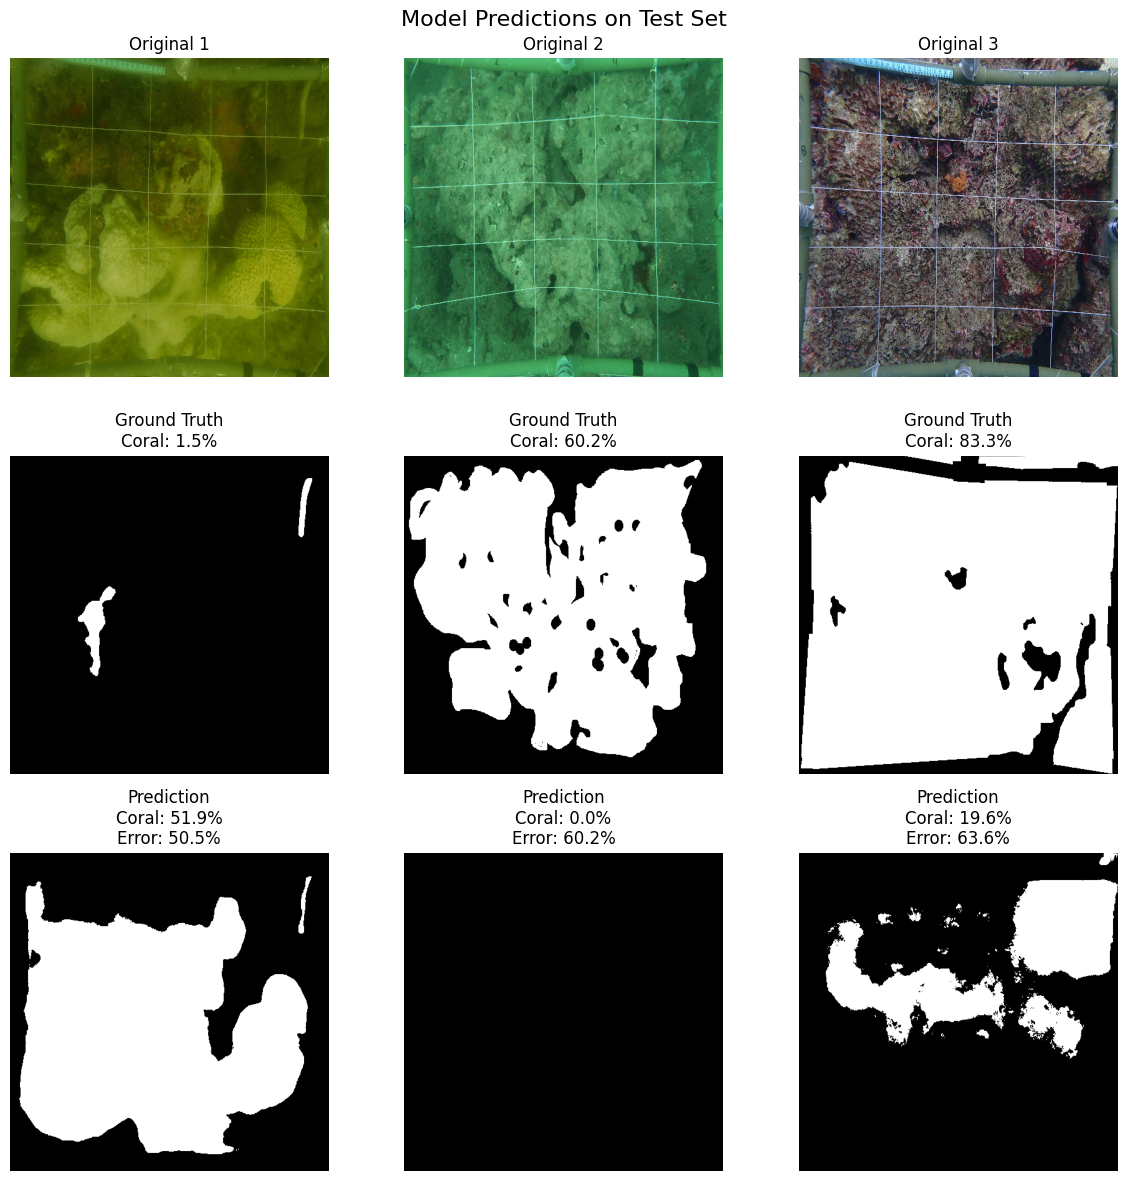

In [34]:
def visualize_predictions(model, dataset, indices=None, num_samples=6):
    """
    Visualize model predictions on sample images.
    """
    if indices is None:
        indices = np.random.choice(len(dataset), num_samples, replace=False)
    
    model.eval()
    
    fig, axes = plt.subplots(3, num_samples, figsize=(4*num_samples, 12))
    
    with torch.no_grad():
        for i, idx in enumerate(indices):
            # Get sample
            image, mask = dataset[idx]
            
            # Add batch dimension
            image_batch = image.unsqueeze(0).to(device)
            
            # Get prediction
            output = model(image_batch)
            prediction = torch.argmax(output, dim=1).squeeze().cpu().numpy()
            
            # Denormalize image for visualization
            mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
            std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
            image_vis = image * std + mean
            image_vis = torch.clamp(image_vis, 0, 1)
            image_np = image_vis.permute(1, 2, 0).numpy()
            
            mask_np = mask.numpy()
            
            # Calculate metrics for this sample
            true_coverage = (mask_np == 1).sum() / mask_np.size * 100
            pred_coverage = (prediction == 1).sum() / prediction.size * 100
            
            # Plot original image
            axes[0, i].imshow(image_np)
            axes[0, i].set_title(f'Original {i+1}')
            axes[0, i].axis('off')
            
            # Plot ground truth
            axes[1, i].imshow(mask_np, cmap='gray')
            axes[1, i].set_title(f'Ground Truth\nCoral: {true_coverage:.1f}%')
            axes[1, i].axis('off')
            
            # Plot prediction
            axes[2, i].imshow(prediction, cmap='gray')
            axes[2, i].set_title(f'Prediction\nCoral: {pred_coverage:.1f}%\nError: {abs(pred_coverage - true_coverage):.1f}%')
            axes[2, i].axis('off')
    
    plt.suptitle('Model Predictions on Test Set', fontsize=16)
    plt.tight_layout()
    plt.show()

# Visualize predictions on test set
print("Sample predictions on test set:")
visualize_predictions(model, test_dataset, num_samples=6)

# Find best and worst predictions for analysis
coverage_errors = np.abs(np.array(coverage_preds) - np.array(coverage_targets))
best_indices = np.argsort(coverage_errors)[:3]  # 3 best predictions
worst_indices = np.argsort(coverage_errors)[-3:]  # 3 worst predictions

print("\nBest predictions (lowest coverage error):")
visualize_predictions(model, test_dataset, indices=best_indices, num_samples=3)

print("\nWorst predictions (highest coverage error):")
visualize_predictions(model, test_dataset, indices=worst_indices, num_samples=3)

## 13. Model Summary and Conclusions

In [35]:
# Save final model summary
model_summary = {
    'model_architecture': 'U-Net with ResNet50 encoder',
    'input_size': IMAGE_SIZE,
    'num_classes': 2,
    'total_parameters': sum(p.numel() for p in model.parameters()),
    'trainable_parameters': sum(p.numel() for p in model.parameters() if p.requires_grad),
    'training_epochs': len(history['train_loss']),
    'best_epoch': checkpoint['epoch'],
    'dataset_size': {
        'total': len(binary_df),
        'train': len(train_data),
        'validation': len(val_data),
        'test': len(test_data)
    },
    'final_metrics': {
        'test_mean_iou': test_iou.mean().item(),
        'test_background_iou': test_iou[0].item(),
        'test_coral_iou': test_iou[1].item(),
        'test_pixel_accuracy': test_pixel_acc,
        'coral_coverage_mae': coverage_mae,
        'coral_coverage_rmse': coverage_rmse
    },
    'training_config': {
        'learning_rate': LEARNING_RATE,
        'batch_size': BATCH_SIZE,
        'loss_function': 'Combined CrossEntropy + Dice Loss',
        'optimizer': 'AdamW',
        'scheduler': 'CosineAnnealingLR',
        'mixed_precision': True,
        'early_stopping_patience': PATIENCE
    }
}

# Save model summary
with open(BINARY_SEG_DIR / 'model_summary.json', 'w') as f:
    json.dump(model_summary, f, indent=2)

print("\n" + "="*80)
print("CORAL SEGMENTATION MODEL - FINAL SUMMARY")
print("="*80)

print(f"\n🏗️  MODEL ARCHITECTURE:")
print(f"   Architecture: {model_summary['model_architecture']}")
print(f"   Input Size: {model_summary['input_size']}")
print(f"   Classes: {model_summary['num_classes']} (Background, Coral)")
print(f"   Parameters: {model_summary['total_parameters']:,}")

print(f"\n📊 DATASET:")
print(f"   Total Images: {model_summary['dataset_size']['total']}")
print(f"   Train/Val/Test: {model_summary['dataset_size']['train']}/{model_summary['dataset_size']['validation']}/{model_summary['dataset_size']['test']}")

print(f"\n🎯 PERFORMANCE METRICS:")
print(f"   Mean IoU: {model_summary['final_metrics']['test_mean_iou']:.4f}")
print(f"   Background IoU: {model_summary['final_metrics']['test_background_iou']:.4f}")
print(f"   Coral IoU: {model_summary['final_metrics']['test_coral_iou']:.4f}")
print(f"   Pixel Accuracy: {model_summary['final_metrics']['test_pixel_accuracy']:.4f}")
print(f"   Coral Coverage MAE: {model_summary['final_metrics']['coral_coverage_mae']:.2f}%")
print(f"   Coral Coverage RMSE: {model_summary['final_metrics']['coral_coverage_rmse']:.2f}%")

print(f"\n⚙️  TRAINING CONFIGURATION:")
print(f"   Epochs Trained: {model_summary['training_epochs']}")
print(f"   Best Epoch: {model_summary['best_epoch']}")
print(f"   Learning Rate: {model_summary['training_config']['learning_rate']}")
print(f"   Batch Size: {model_summary['training_config']['batch_size']}")
print(f"   Loss Function: {model_summary['training_config']['loss_function']}")

print(f"\n💾 SAVED FILES:")
print(f"   Best Model: {best_model_path}")
print(f"   Training History: {BINARY_SEG_DIR / 'training_history.csv'}")
print(f"   Model Summary: {BINARY_SEG_DIR / 'model_summary.json'}")
print(f"   Dataset Info: {BINARY_SEG_DIR / 'binary_dataset_info.csv'}")
print(f"   Dataset Splits: {BINARY_SEG_DIR / 'dataset_splits.json'}")

print(f"\n🚀 MODEL READY FOR:")
print(f"   ✓ Coral detection in underwater images")
print(f"   ✓ Coral coverage estimation")
print(f"   ✓ Marine ecosystem monitoring")
print(f"   ✓ Environmental research applications")

print("\n" + "="*80)
print("🎉 CORAL SEGMENTATION MODEL TRAINING COMPLETE! 🎉")
print("="*80)


CORAL SEGMENTATION MODEL - FINAL SUMMARY

🏗️  MODEL ARCHITECTURE:
   Architecture: U-Net with ResNet50 encoder
   Input Size: (512, 512)
   Classes: 2 (Background, Coral)
   Parameters: 32,521,250

📊 DATASET:
   Total Images: 658
   Train/Val/Test: 394/132/132

🎯 PERFORMANCE METRICS:
   Mean IoU: 0.7021
   Background IoU: 0.7978
   Coral IoU: 0.6065
   Pixel Accuracy: 0.8475
   Coral Coverage MAE: 9.58%
   Coral Coverage RMSE: 15.40%

⚙️  TRAINING CONFIGURATION:
   Epochs Trained: 47
   Best Epoch: 36
   Learning Rate: 0.0001
   Batch Size: 8
   Loss Function: Combined CrossEntropy + Dice Loss

💾 SAVED FILES:
   Best Model: ../data/binary_segmentation/best_coral_segmentation_model.pth
   Training History: ../data/binary_segmentation/training_history.csv
   Model Summary: ../data/binary_segmentation/model_summary.json
   Dataset Info: ../data/binary_segmentation/binary_dataset_info.csv
   Dataset Splits: ../data/binary_segmentation/dataset_splits.json

🚀 MODEL READY FOR:
   ✓ Coral det